In [1]:
import matplotlib as mp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import scipy as sp
import time

In [2]:
#opens .dat files to be converted into CSVs
#change pathprefix on different computers
EOS_files = "/home/tplohr/proj/SF 24-25/diettim NMMA master EOS-chiralEFT_MTOV/"
LIGO_data = "/home/tplohr/proj/SF 24-25/data/GW170817.dat"
def loadEOS(number, pathprefix):
    file = open(pathprefix + str(number) + '.dat', 'r')
    return file

In [20]:
#creates an empty array to contain all EOSs 
numofEOS = 5000
EOSs = [None] * numofEOS

#fills "EOSs" with arrays of each EOS's mass and radius values 
for i in range(numofEOS):
    df = pd.read_csv(loadEOS(i+1, EOS_files), delimiter = '\t', names = ["radius", "mass", "deformability"])
    EOSs[i] = np.array([df["deformability"], df["mass"], df["radius"]])
#EOSs[i] is EOS_i
#EOSs[i][0] is the list of deformability values of EOS_i
#EOSs[i][1] is the list of mass values of EOS_i
#EOSs[i][0][j] is the deformability value indexed j of EOS_i
#EOSs[i][1][j] is the mass value indexed j of EOS_i

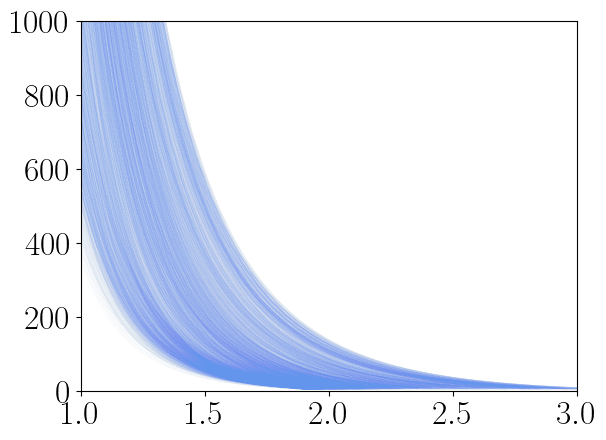

In [4]:
#plots each EOS 
for i in range(numofEOS):
    plt.xlim([1,3])
    plt.ylim([0,1000])
    plt.rcParams['figure.figsize'] = [8,3]
    plt.plot(EOSs[i][1], EOSs[i][0], 'cornflowerblue', linewidth=.01)

In [5]:
#initialization of probability arrays

#probabilities of the EOSs given the observations, each index corresponds to one EOS; posterior
P_EOS_given_obs = np.zeros(numofEOS)
#probabilities of the observations given an EOS; likelihood
P_obs_given_EOS = np.zeros(numofEOS)
#probabilities of the EOSs without a condition; prior
P_EOS = np.ones(numofEOS)/numofEOS

In [6]:
#reading in the data from LIGO
dataframe = pd.read_csv(LIGO_data, delim_whitespace=True, header=0)
selected_columns = dataframe.iloc[:,[2,3,4,5]]
#data[:,0] is m1, data[:,1] is m2, data[:,2] is lambda1, data[:,3] is lambda2
raw_data = selected_columns.to_numpy()
#making data have the same shape
data = np.copy(raw_data)
data[:, [0,1]] = raw_data[:, [0,1]]/1.0099
data[:, [2,3]] = raw_data[:, [2,3]]
#using a KDE to get the probability density function for the likelihood
pdf = sp.stats.gaussian_kde((data[:,0], data[:,1], data[:,2], data[:,3]))

In [7]:
#calculate the probability of the observations given an EOS; likelihood
num_points = 100
def calc_P_obs_given_EOS(i):
    #lambda is the interpolated function lambda(m)
    lambda_func = sp.interpolate.interp1d(EOSs[i][1], EOSs[i][0])
    #min, max, and range of mass for a given EOS
    min_m = np.min(EOSs[i][1])
    max_m = np.max(EOSs[i][1])
    len_m = max_m-min_m
    #change in mass between every point
    delta_m = len_m/(num_points-1)
    #m is an array of all the mass values to sum over
    m = np.linspace(min_m, max_m, num_points)
    
    P = 0
    #loop over each mass value to set m1 and lambda1
    for j in range(num_points):
        m1 = m[j]
        lambda1 = lambda_func(m1)
        #loop over each mass value to set m2 and lambda2
        for k in range(num_points):
            m2 = m[k]
            lambda2 = lambda_func(m2)
            #probability of the mass1-mass2-lambda1-lambda2 point
            pdf_value = pdf.evaluate((m1, m2, lambda1, lambda2))
        
            #probability of EOS_i is the sum of the probability of each point multiplied by the distance to the next point
            P += pdf_value*delta_m**2
    return P

In [8]:
start=time.time()
norm_factor = 0
for i in range(numofEOS):
    #calculate the likelihood
    P_obs_given_EOS[i] = calc_P_obs_given_EOS(i)
    #calculate the denominator (sum of the numerator)
    norm_factor += P_obs_given_EOS[i]

for i in range(numofEOS):
    #calculate the posterior
    P_EOS_given_obs[i] = P_obs_given_EOS[i] / norm_factor
end=time.time()
print(end-start)

16410.053765773773


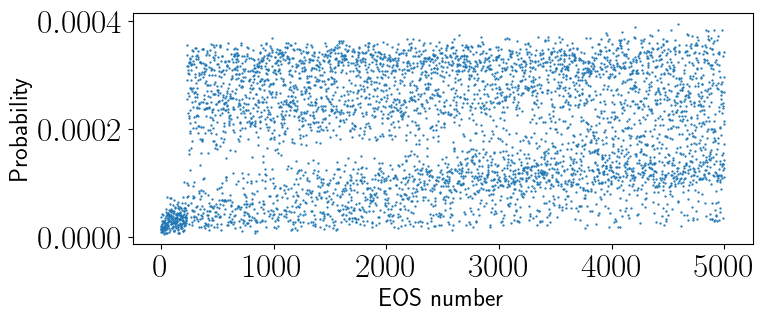

In [9]:
plt.xlabel("EOS number", fontsize=18)
plt.ylabel("Probability", fontsize=18)
plt.scatter(np.linspace(0,numofEOS,5000), P_EOS_given_obs, s=0.4)

In [10]:
tot_prob = 0
for i in range(numofEOS):
    tot_prob += P_EOS_given_obs[i]
print(tot_prob)

1.0000000000000022


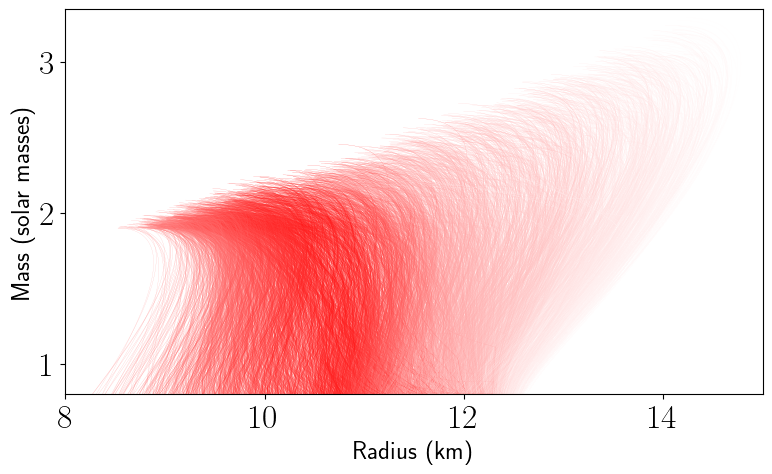

In [25]:
#plotting each EOS; low probability is white, high probability is red
cmap2 = mp.colors.LinearSegmentedColormap.from_list("white_to_red", ["white","red"])
norm2 = plt.Normalize(P_EOS_given_obs.min(), P_EOS_given_obs.max())
#plots each EOS 
for i in range(numofEOS):
    color = cmap2(norm2(P_EOS_given_obs[i]))
    plt.xlim([8,15])
    plt.ylim([.8,3.35])
    plt.xlabel("Radius (km)", fontsize=18)
    plt.ylabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][2], EOSs[i][1], color=color, linewidth=.1)

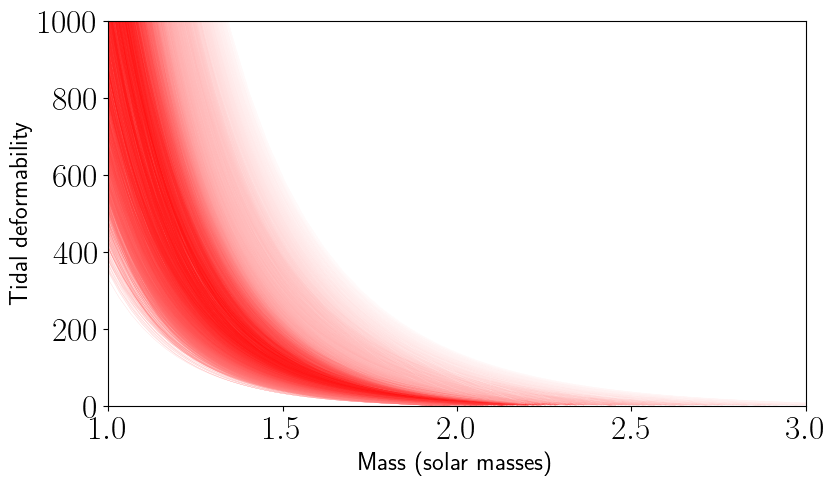

In [30]:
#plots each EOS 
for i in range(numofEOS):
    color = cmap2(norm2(P_EOS_given_obs[i]))
    plt.xlim([1,3])
    plt.ylim([0,1000])
    plt.ylabel("Tidal deformability", fontsize=18)
    plt.xlabel("Mass (solar masses)", fontsize=18)
    plt.rcParams['figure.figsize'] = [9,5]
    plt.plot(EOSs[i][1], EOSs[i][0], color=color, linewidth=.1)